In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, PrecisionRecallDisplay
from imblearn.over_sampling import RandomOverSampler
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
goalies = pd.read_csv('data/goalies.csv')
goalies = goalies.drop(columns=['Unnamed: 0'])
goalies.head(10)

,vote-share,gps,g-wins,g-losses,gaa,save-percentage,mvp
0,11.66,14.0,31,22,2.98,0.903,0
1,2.55,11.4,32,23,3.18,0.895,0
2,41.80,11.6,33,14,3.35,0.894,0
3,1.06,7.9,23,10,3.44,0.892,0
4,0.35,12.6,35,18,3.26,0.893,0
5,0.18,10.1,23,10,2.96,0.898,0
6,0.95,10.0,26,15,3.48,0.894,0
7,0.63,10.3,20,18,3.36,0.893,0
8,50.48,16.5,40,12,2.37,0.903,0
9,0.63,9.2,15,35,3.98,0.875,0


In [3]:
X = goalies.drop(columns=['mvp', 'vote-share', 'g-losses'])
Y = goalies['mvp']

x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=33, shuffle=True, stratify=Y)

In [4]:
columns_to_scale = ['gps', 'g-wins', 'gaa']
columns_no_scale = [col for col in x_train.columns if col not in columns_to_scale]

scaler = ColumnTransformer(
    transformers=[
        ('scaler', StandardScaler(), columns_to_scale),
        ('no_scaler', 'passthrough', columns_no_scale)
    ]
)

x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

In [5]:
x_train = pd.DataFrame(x_train, columns=(columns_to_scale + columns_no_scale))
x_test = pd.DataFrame(x_test, columns=(columns_to_scale + columns_no_scale))

In [6]:
ros = RandomOverSampler(random_state=33)
x_train_ros, y_train_ros = ros.fit_resample(x_train, y_train)

In [7]:
rf_classifier = RandomForestClassifier(random_state=33)

rf_classifier.fit(x_train_ros, y_train_ros)

RandomForestClassifier(random_state=33)

In [8]:
y_pred = rf_classifier.predict(x_test)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='binary')
recall = recall_score(y_test, y_pred, average='binary')
f1 = f1_score(y_test, y_pred, average='binary')

print(f'Accuracy: {accuracy:.2f}')
print(f'Precision: {precision:.2f}')
print(f'Recall: {recall:.2f}')
print(f'F1 Score: {f1:.2f}')

Accuracy: 1.00
Precision: 1.00
Recall: 1.00
F1 Score: 1.00


In [9]:
param_grid = {
    'n_estimators': [10, 20, 50, 100],
    'max_depth': [5, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False],
    'class_weight': ['balanced', None]
}

grid_search = GridSearchCV(estimator=rf_classifier, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2, scoring='f1')

grid_search.fit(x_train_ros, y_train_ros)
tuned_rf = grid_search.best_estimator_

y_pred = tuned_rf.predict(x_test)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='binary')
recall = recall_score(y_test, y_pred, average='binary')
f1 = f1_score(y_test, y_pred, average='binary')

print(f'Accuracy: {accuracy:.2f}')
print(f'Precision: {precision:.2f}')
print(f'Recall: {recall:.2f}')
print(f'F1 Score: {f1:.2f}')

Fitting 5 folds for each of 576 candidates, totalling 2880 fits
Accuracy: 1.00
Precision: 1.00
Recall: 1.00
F1 Score: 1.00


In [10]:
grid_search.best_params_

{'bootstrap': True,
 'class_weight': 'balanced',
 'max_depth': 5,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 10}

In [11]:
cm = confusion_matrix(y_test, y_pred)

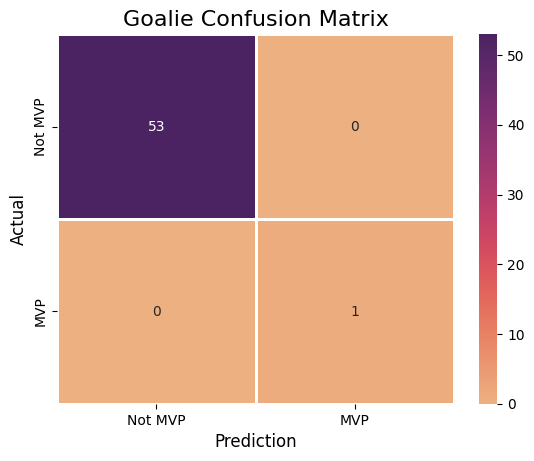

In [12]:
sns.heatmap(cm, annot=True, xticklabels=['Not MVP', 'MVP'], yticklabels=['Not MVP', 'MVP'], cmap='flare',
            fmt='g', linecolor='white', linewidth=1
        )

plt.xlabel('Prediction', fontsize=12)
plt.ylabel('Actual', fontsize=12)
plt.title('Goalie Confusion Matrix', fontsize=16)
plt.savefig('visuals/goalie_confusion.png')
plt.show()

In [13]:
scores = tuned_rf.predict_proba(x_test)

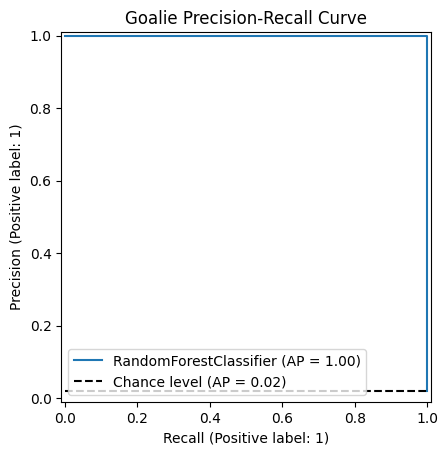

In [14]:
display = PrecisionRecallDisplay.from_predictions(
    y_test, scores[:, 1], name='RandomForestClassifier', plot_chance_level=True
)

display.ax_.set_title('Goalie Precision-Recall Curve')
plt.savefig('visuals/goaliePRC.png')
plt.show()

In [15]:
data2025 = pd.read_csv('data/2025_g_forecast.csv')
data2025.head()

,Unnamed: 0,player names,gps,wins,gaa,sv%
0,0,Connor Hellebuyck,17.1,54,2.09,0.927
1,1,Filip Gustavsson,15.9,42,2.08,0.927
2,2,Juuse Saros,14.1,18,2.72,0.908
3,3,Joey Daccord,13.2,36,2.42,0.916
4,4,Igor Shesterkin,13.2,27,2.95,0.910


In [16]:
data2025 = data2025.drop(columns=['Unnamed: 0'])
names = data2025.pop('player names')

In [21]:
data2025 = data2025.rename(columns={
    'wins': 'g-wins',
    'sv%': 'save-percentage'
})

data2025.head()

,gps,g-wins,gaa,save-percentage
0,17.1,54,2.09,0.927
1,15.9,42,2.08,0.927
2,14.1,18,2.72,0.908
3,13.2,36,2.42,0.916
4,13.2,27,2.95,0.910


In [22]:
cols = data2025.columns

data2025 = scaler.transform(data2025)

data2025 = pd.DataFrame(data2025, columns=cols)

In [23]:
probs = tuned_rf.predict_proba(data2025)
probs[:, 1]

array([0.29642857, 0.1       , 0.        , 0.        , 0.        ,
       0.        ])

In [24]:
df_probs = pd.DataFrame({
    'Name': names,
    '% Predicted MVP': probs[:, 1]
})

In [26]:
df_probs.sort_values(by=['% Predicted MVP'], ascending=False).reset_index(drop=True)

,Name,% Predicted MVP
0,Connor Hellebuyck,0.296429
1,Filip Gustavsson,0.100000
2,Juuse Saros,0.000000
3,Joey Daccord,0.000000
4,Igor Shesterkin,0.000000
5,Lukáš Dostál,0.000000
